# Figures
Generic figures for timelag synthesis paper

In [1]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
from sunpy.map import Map
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize,SqrtStretch,AsinhStretch
import plasmapy.atomic
from scipy.interpolate import splev
from astropy.table import Table,Column
from astropy.io import ascii
from fiasco import list_elements

import synthesizAR
from synthesizAR.atomic import EmissionModel,Element
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import bgry_004_idl_cmap

sys.path.append('../paper/python/')
from formatting import rwb_cmap,get_figsize,hist_step,heating_palette,qualitative_palette,timelag_cmap

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

## Heating
Plot the temperature, density, and heating for the three primary heating cases. 

In [3]:
ar_high = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/field_checkpoint/', lazy=True)
ar_intermediate = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/field_checkpoint/', lazy=True)
ar_low = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/field_checkpoint/', lazy=True)

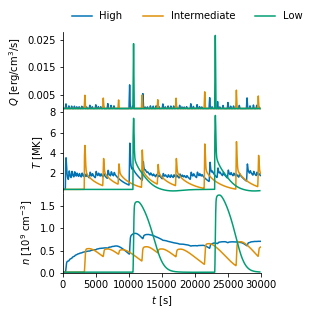

In [4]:
fig,axes = plt.subplots(3,1,figsize=get_figsize(wf=0.5,hf=1.25),sharex=True)
plt.subplots_adjust(hspace=0.)
colors = heating_palette()
i_loop=680
# Heating
## Read the heating 
h = np.loadtxt(os.path.join(os.path.dirname(
    ar_high.loops[i_loop].parameters_savefile),f'hydro_results/{ar_high.loops[i_loop].name}'))[:,-1]
axes[0].plot(ar_high.loops[i_loop].time, h, color=colors[0],label='High',)
h = np.loadtxt(os.path.join(os.path.dirname(
    ar_intermediate.loops[i_loop].parameters_savefile),f'hydro_results/{ar_intermediate.loops[i_loop].name}'))[:,-1]
axes[0].plot(ar_intermediate.loops[i_loop].time, h, color=colors[1],label='Intermediate',)
h = np.loadtxt(os.path.join(os.path.dirname(
    ar_low.loops[i_loop].parameters_savefile),f'hydro_results/{ar_low.loops[i_loop].name}'))[:,-1]
axes[0].plot(ar_low.loops[i_loop].time, h, color=colors[2],label='Low',)
axes[0].legend(ncol=3,loc="lower left", bbox_to_anchor=(0.,1.02),frameon=False,)

# Temperature
axes[1].plot(ar_high.loops[i_loop].time,ar_high.loops[i_loop].electron_temperature[:,0].to(u.MK),
             color=colors[0],)
axes[1].plot(ar_intermediate.loops[i_loop].time,ar_intermediate.loops[i_loop].electron_temperature[:,0].to(u.MK),
             color=colors[1],)
axes[1].plot(ar_low.loops[i_loop].time,ar_low.loops[i_loop].electron_temperature[:,0].to(u.MK),
             color=colors[2],)

# Density
axes[2].plot(ar_high.loops[i_loop].time,ar_high.loops[i_loop].density[:,0]/1e9,
             color=colors[0],)
axes[2].plot(ar_intermediate.loops[i_loop].time,ar_intermediate.loops[i_loop].density[:,0]/1e9,
             color=colors[1],)
axes[2].plot(ar_low.loops[i_loop].time,ar_low.loops[i_loop].density[:,0]/1e9,
             color=colors[2],)

# Labels and limits
axes[0].set_xlim(0,3e4)
#axes[0].set_ylim(-1e-3,2e-2)
axes[0].set_yticks([0.005,0.015,0.025])
axes[1].set_ylim(0.1,8)
#axes[1].set_yticks(axes[1].get_yticks()[1:-1])
axes[2].set_ylim(0,1.8)
axes[0].set_ylabel(r'$Q$ [erg$/$cm$^{3}$$/$s]')
axes[1].set_ylabel(r'$T$ [MK]')
axes[2].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[2].set_xlabel(r'$t$ [s]')
# Spines
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].tick_params(axis='x',which='both',bottom=False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].tick_params(axis='x',which='both',bottom=False)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
# Save
#fig.savefig('figures/hydro_profiles.pdf',)

## Phase Space Plot
Show $n-T$ phase space with a line of constant pressure overlaid.

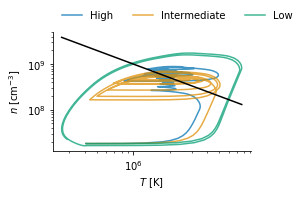

In [5]:
fig = plt.figure(figsize=get_figsize(wf=0.5))
colors = heating_palette()
ax = fig.gca()
labels = ['High','Intermediate','Low']
min_T = 1e300*u.K
max_T = 0*u.K
for i,loop in enumerate([ar_high.loops[i_loop],ar_intermediate.loops[i_loop],ar_low.loops[i_loop]]):
    ax.plot(loop.electron_temperature[:,0],loop.density[:,0],color=colors[i],alpha=0.75,label=labels[i])
    min_T = min(min_T, loop.electron_temperature.min())
    max_T = max(max_T, loop.electron_temperature.max())
p = 1e15*u.K/(u.cm**3)
T = np.linspace(min_T,max_T,1000)
ax.plot(T,p/T,color='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$n$ [cm$^{-3}$]')
ax.set_xlabel(r'$T$ [K]')
ax.legend(ncol=3,loc="lower left", bbox_to_anchor=(0.,1.02),frameon=False,)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#fig.savefig('figures/nt_phase_space.pdf')

## Element Table
List elements, number of ions, total number of lines

In [6]:
em = EmissionModel.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_emission_model.json')

In [7]:
by_element = {}
for i in em:
    el = i.atomic_symbol
    if el not in by_element:
        by_element[el] = [i]
    else:
        by_element[el].append(i)
by_element = {k: sorted(v, key=lambda x:x.atomic_number) for k,v in by_element.items()}

In [8]:
col1 = [e[0].atomic_symbol for e in sorted([v for _,v in by_element.items()], key=lambda x: x[0].atomic_number)]

In [9]:
col2 = [len(by_element[x]) for x in col1]

In [10]:
col3 = [sum([i.transitions.wavelength.shape[0] for i in by_element[x] if i.transitions is not None]) for x in col1]

In [11]:
t = Table([col1, col2, col3], names=('Element', 'Number of Ions', 'Number of Transitions'),
          meta={'name': 'CHIANTI Elements'})

In [12]:
t

Element,Number of Ions,Number of Transitions
str2,int64,int64
O,9,11892
Mg,13,31965
Si,15,30047
S,17,32102
Ca,21,42823
Fe,27,553541
Ni,29,83517


In [19]:
caption = r"""Elements included in the calculation of \autoref{eq:intensity}. Ions and transitions are those included in the CHIANTI atomic database.\label{tab:elements}
"""

In [20]:
ascii.write(t, output='tex/element_table.tex', format='aastex',caption=caption,overwrite=True)

## Effective Response Functions
Show the response functions when including the selected elements

In [13]:
aia = InstrumentSDOAIA([0,1]*u.s,observer_coordinate=None)

In [14]:
calc_temp_response = {}
for channel in aia.channels:
    counts = np.zeros(em.temperature.shape+em.density.shape)
    components = {}
    for ion in em:
        wvl,emiss = em.get_emissivity(ion)
        if wvl is None or emiss is None:
            continue
        response = splev(wvl.value, channel['wavelength_response_spline'])
        response = np.where(response < 0., 0., response)
        tmp = np.dot(emiss.value, response)
        tmp *= ion.abundance.value*ion.ioneq.value[:,np.newaxis]/em.density.value/4./np.pi
        counts += tmp
        if ion.element_name in components:
            components[ion.element_name] += tmp
        else:
            components[ion.element_name] = tmp
    calc_temp_response[channel['name']] = counts
    calc_temp_response[f'{channel["name"]}_components'] = components

In [15]:
p = 10**(15)*u.K/(u.cm**3)
const_p_indices = np.array([(i,np.argmin(np.fabs(em.density.value-d.value))) 
                            for i,d in enumerate(p/em.temperature)])

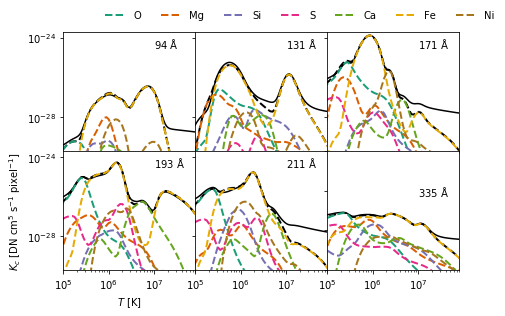

In [16]:
fig,axes = plt.subplots(2,3,figsize=get_figsize(wf=1,),sharex=True,sharey=True)
colors = qualitative_palette(len(calc_temp_response['94_components']))
data_temperature = np.logspace(5,8,100)
for i,(ax,channel) in enumerate(zip(axes.flatten(),aia.channels)):
    real_response = splev(data_temperature, channel['temperature_response_spline'])
    ax.plot(data_temperature, real_response, ls='-',color='k',)
    ax.plot(em.temperature, calc_temp_response[channel['name']][const_p_indices[:,0],const_p_indices[:,1]],
            color='k',ls='--',lw=2)
    elements = sorted(list(calc_temp_response[f'{channel["name"]}_components']), key=lambda x: plasmapy.atomic.atomic_number(x))
    for j,element in enumerate(elements):
        ax.plot(em.temperature,
                calc_temp_response[f'{channel["name"]}_components'][element][const_p_indices[:,0],const_p_indices[:,1]],
                color=colors[j], ls='--', label=plasmapy.atomic.atomic_symbol(element), lw=2)
    if i==0:
        ax.legend(ncol=len(elements),loc="lower left", bbox_to_anchor=(0.25,1.02),frameon=False)
    ax.text(1e7,3e-25,f'{channel["name"]} $\mathrm{{\AA}}$',fontsize=plt.rcParams['axes.labelsize'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-30,2e-24])
ax.set_xlim([1e5,8e7])
ax.set_yticks(ax.get_yticks()[::2])
axes[1,0].set_ylabel(r'$K_c$ [DN cm$^5$ s$^{-1}$ pixel$^{-1}$]')
axes[1,0].set_xlabel(r'$T$ [K]')
plt.subplots_adjust(wspace=0.,hspace=0.)
#fig.savefig('figures/aia_response.pdf')

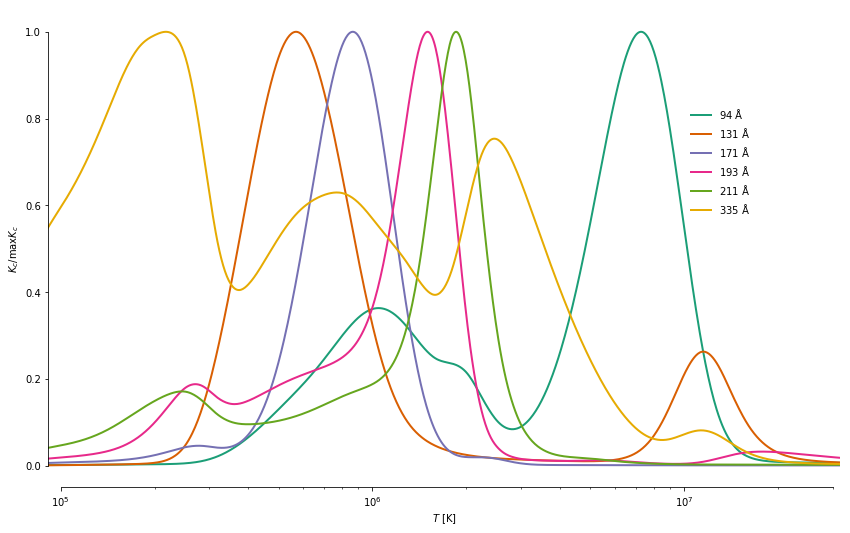

In [17]:
fig = plt.figure(figsize=get_figsize(wf=2.))
ax = fig.gca()
t = np.logspace(4.5,7.5,1000)
colors = qualitative_palette(len(aia.channels))
tmax = {}
for i,c in enumerate(aia.channels):
    r = splev(t, c['temperature_response_spline'])
    ax.plot(t,r/r.max(),lw=2,color=colors[i],label=f"{c['name']} $\mathrm{{\AA}}$")
    tmax[c['name']] = t[np.argmax(r)]
ax.set_xscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(1e5,3e7)
ax.set_ylim(-0.05,1.05)
ax.set_xlim(9.1e4,t[-1])
ax.legend(loc="lower left", bbox_to_anchor=(0.8,0.55),frameon=False,ncol=1)
ax.set_ylabel(r'$K_c/\max{K_c}$');
ax.set_xlabel(r'$T$ [K]');